## Importowanie bibliotek potrzebnych do realizacji zadania

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import os
import sys
from pathlib import Path

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

import pickle
import shap

working_dir = Path(os.getcwd()).parent
sys.path.append(os.path.join(working_dir, 'Preprocessing\\'))

from data_aggregator import *
from season import *
from parameters import *
from team import *

from split_start import *
from split_block import *
from prepare_dataset import *

## Przygotowanie danych - pobranie przetworzonych danych do pamięci podręcznej

In [2]:
no_last_matches = 3

data_aggregator = DataAggregator()

all_seasons, all_data_past =\
                    data_aggregator.get_data_for_seasons([Season.y2010, Season.y2011,
                                                         Season.y2012, Season.y2013,
                                                         Season.y2014, Season.y2015, Season.y2016], 
                                                         Parameters(no_last_matches=no_last_matches))

# Wstępna inspekcja poprawności pobranych danych

In [3]:
all_seasons['match_date'] = pd.to_datetime(all_seasons['match_date'])

In [4]:
all_seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269 entries, 0 to 2268
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   match_id                      2269 non-null   int64         
 1   home_team_id                  2269 non-null   int64         
 2   away_team_id                  2269 non-null   int64         
 3   home_team_name                2269 non-null   object        
 4   away_team_name                2269 non-null   object        
 5   match_date                    2269 non-null   datetime64[ns]
 6   match_result                  2269 non-null   int64         
 7   home_team_score               2269 non-null   float64       
 8   away_team_score               2269 non-null   float64       
 9   home_team_seasons_played      2269 non-null   int64         
 10  away_team_seasons_played      2269 non-null   int64         
 11  home_team_last_season_points  

In [5]:
all_seasons.describe()

,match_id,home_team_id,away_team_id,match_result,home_team_score,away_team_score,home_team_seasons_played,away_team_seasons_played,home_team_last_season_points,away_team_last_season_points,...,home_avg_shots,away_avg_shots,home_won_games,away_won_games,home_tied_games,away_tied_games,home_lost_games,away_lost_games,home_scored_goals,away_scored_goals
count,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.00000,2269.000000,2269.000000,...,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000
mean,3629.479506,4144.372851,4144.682239,1.033495,51.565297,51.546853,3.372851,3.37197,47.483914,47.509476,...,5.617506,5.816875,1.073601,1.154694,0.771265,0.769502,1.147201,1.069193,4.005729,4.180256
std,658.387855,1326.480329,1328.487674,0.741041,5.123285,5.114102,2.038493,2.03649,24.413840,24.403763,...,2.404072,2.429016,0.863912,0.890054,0.757760,0.739551,0.875604,0.857619,2.277771,2.326262
min,2489.000000,3457.000000,3457.000000,0.000000,40.750000,40.750000,0.000000,0.00000,0.000000,0.000000,...,0.670000,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3060.000000,3461.000000,3461.000000,0.000000,48.500000,48.500000,2.000000,2.00000,39.000000,39.000000,...,3.670000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000
50%,3629.000000,3467.000000,3467.000000,1.000000,50.880000,50.880000,3.000000,3.00000,47.000000,47.000000,...,5.330000,5.330000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000
75%,4199.000000,3475.000000,3475.000000,2.000000,54.380000,54.380000,5.000000,5.00000,64.000000,64.000000,...,7.000000,7.330000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,5.000000,6.000000
max,4768.000000,8784.000000,8784.000000,2.000000,70.000000,70.000000,7.000000,7.00000,89.000000,89.000000,...,15.000000,17.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,16.000000


In [6]:
# Przykład użycia
get_direct_matches_by_id(2489, all_data_past, 3)

,home_team_id,away_team_id,home_team_name,away_team_name,match_date,match_result
0,3465,3463,Aston Villa,West Ham United,2010-01-17,0
1,3463,3465,West Ham United,Aston Villa,2009-11-04,1
2,3465,3463,Aston Villa,West Ham United,2009-04-18,0
3,3463,3465,West Ham United,Aston Villa,2008-12-20,2


In [7]:
list_of_parameters = ['home_team_score',
                        'away_team_score', 
                        'home_team_seasons_played',
                        'away_team_seasons_played', 
                        'home_team_last_season_points',
                        'away_team_last_season_points', 
                        'home_players_avg_age',
                        'away_players_avg_age', 
                        'home_players_avg_rating',
                        'away_players_avg_rating', 
                        'home_elo_rating', 
                        'away_elo_rating',
                        'avg_home_win_odds', 
                        'avg_draw_odds', 
                        'avg_away_win_odds',
                        'home_avg_corners', 
                        'away_avg_corners', 
                        'home_avg_shots',
                        'away_avg_shots', 
                        'home_won_games', 
                        'away_won_games', 
                        'home_tied_games',
                        'away_tied_games', 
                        'home_lost_games', 
                        'away_lost_games',
                        'home_scored_goals', 
                        'away_scored_goals'
                     ]

In [8]:
dataset = prepare_dataset(all_seasons, list_of_parameters, all_data_past,
                          add_direct = True, avg = 3, train_size = 0.85, test_size = 0.1,
                          undersample = True, globalCS = False)

In [9]:
Counter(dataset['y_train'])

Counter({1: 572, 0: 489, 2: 562})

In [10]:
dataset['X']

,home_team_score,away_team_score,home_team_seasons_played,away_team_seasons_played,home_team_last_season_points,away_team_last_season_points,home_players_avg_age,away_players_avg_age,home_players_avg_rating,away_players_avg_rating,...,away_won_games,home_tied_games,away_tied_games,home_lost_games,away_lost_games,home_scored_goals,away_scored_goals,home_direct_wins,away_direct_wins,direct_draws
0,55.50,46.12,2,2,64,35,28.09,27.55,79.27,73.73,...,1,0,1,2,1,2,6,1,1,2
2,56.25,54.38,2,2,39,46,27.73,29.45,73.55,75.45,...,1,1,0,1,2,4,3,0,2,2
3,56.38,63.75,2,1,86,0,29.36,25.73,83.91,70.45,...,1,0,1,0,1,17,3,2,0,0
7,50.62,40.75,2,2,63,75,27.55,25.64,82.45,79.55,...,1,1,1,1,1,4,5,0,2,2
4,58.12,70.00,2,1,44,50,24.82,27.73,74.82,76.82,...,1,0,0,2,2,2,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,47.88,57.25,3,1,60,41,27.27,27.55,77.00,73.55,...,1,0,1,1,1,8,6,1,1,0
1978,41.50,48.50,4,7,56,54,27.27,27.00,76.27,76.73,...,2,2,1,1,0,3,5,3,3,2
1974,50.62,48.62,7,7,64,62,24.91,25.27,79.18,79.18,...,1,1,2,0,0,7,5,6,7,1
1975,48.62,44.25,0,7,0,75,27.36,27.55,73.09,82.18,...,2,1,0,1,1,3,8,0,0,1


In [11]:
train_stats = dataset['X_train'].describe()
train_stats

,home_team_score,away_team_score,home_team_seasons_played,away_team_seasons_played,home_team_last_season_points,away_team_last_season_points,home_players_avg_age,away_players_avg_age,home_players_avg_rating,away_players_avg_rating,...,away_won_games,home_tied_games,away_tied_games,home_lost_games,away_lost_games,home_scored_goals,away_scored_goals,home_direct_wins,away_direct_wins,direct_draws
count,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,...,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000
mean,52.161436,52.054695,3.020949,3.112754,46.266174,48.489217,27.324948,27.281528,75.867511,76.159575,...,1.186691,0.759088,0.751694,1.160813,1.058534,4.020949,4.223660,1.720271,1.823783,1.407270
std,5.192251,5.203524,1.792106,1.781942,24.404082,24.307798,1.487733,1.463372,3.553325,3.676721,...,0.903628,0.750997,0.743626,0.868346,0.856339,2.268816,2.375612,1.872805,1.935393,1.257724
min,40.750000,40.750000,0.000000,0.000000,0.000000,0.000000,23.450000,23.450000,66.730000,67.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.750000,48.750000,2.000000,2.000000,38.000000,40.000000,26.270000,26.270000,73.180000,73.270000,...,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000
50%,51.620000,51.620000,3.000000,3.000000,47.000000,47.000000,27.360000,27.270000,75.090000,75.360000,...,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000
75%,54.750000,54.500000,4.000000,5.000000,64.000000,67.000000,28.360000,28.270000,78.730000,79.405000,...,2.000000,1.000000,1.000000,2.000000,2.000000,5.000000,6.000000,3.000000,3.000000,2.000000
max,70.000000,70.000000,7.000000,7.000000,89.000000,89.000000,32.000000,32.000000,84.450000,84.090000,...,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,16.000000,10.000000,11.000000,7.000000


## Algorytm SNN

In [12]:
def norm(x):
    return np.array((x - train_stats['mean']) / train_stats['std'])

In [13]:
# Utworzenie dziennika logów do zapisu historii epok
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

In [14]:
# zdefiniowanie wczesnego zarzymywania algorytmu

early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [15]:
#Utworzenie własnej klasy MonteCarlo Dropout
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [16]:
def get_model():
    return keras.models.Sequential([
    keras.layers.Dense(40, activation = 'relu', input_shape=X_train_dense.shape[1:]),
    keras.layers.BatchNormalization(),
    MCDropout(0.3),
    keras.layers.Dense(40, activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation = 'softmax') ])

In [17]:
dataset = prepare_dataset(all_seasons, list_of_parameters, all_data_past,
                          add_direct = True, avg = 3, train_size = 0.85, test_size = 0.1,
                          undersample = True, globalCS = False)

X_train_dense = np.array(dataset['X_train'])
X_valid_dense = np.array(dataset['X_valid'])
X_test_dense = np.array(dataset['X_test'])

#Wyczyszczenie sesji i ustawienie ziarna losowaości na 42
tf.keras.backend.clear_session()
tf.random.set_seed(42)

#pobranie przygotowanego modelu SNN
model_dense = get_model()

#kompilacja modelu z wybranymi parametrami
model_dense.compile(optimizer='nadam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
#Proces nauki modelu
history_dense = model_dense.fit(X_train_dense, dataset['y_train'], 
                                validation_data=(X_valid_dense, dataset['y_valid']),
                                epochs = 80, 
                                callbacks=[early_stopping_cb], 
                                verbose = 0)

#Przepuszczanie zbioru testowego przez nauczony model (100x per przykład w celu stackowania wyników i wykorzystanie MCDropout)
y_probas_dense = np.stack([model_dense(X_test_dense) for sample in range(100)])
#Wyliczenie średniego wyniku dla każdego z przykładu
y_proba_dense = y_probas_dense.mean(axis=0)

In [18]:
print(f'ilość epok potrzebnych do uzyskania zbierzności: {history_dense.epoch[-1]}')

ilość epok potrzebnych do uzyskania zbierzności: 21


In [19]:
#Odczyt wyników
result_dense = list()
for i in range(y_proba_dense.shape[0]):
    result_dense.append(np.argmax(y_proba_dense[i]))
accuracy = np.sum(result_dense == dataset['y_test']) / len(dataset['y_test'])

print('\n##################################\nAccuracy: ')

print(accuracy)

temp = precision_recall_fscore_support(dataset['y_test'], result_dense, average='macro')
print(f'\n##################################\nPrecision: {temp[0]}\nRecall: {temp[1]}\nfscore: {temp[2]}')

roc_ovo_macro = roc_auc_score(dataset['y_test'], y_proba_dense, multi_class="ovo", average="macro")
roc_ovr_macro = roc_auc_score(dataset['y_test'], y_proba_dense, multi_class="ovr", average="macro")
print(f"\n##################################\nOvO: {roc_ovo_macro}\nOvR: {roc_ovr_macro}")

print(f"\n##################################\n")
print(f'Poprawnie sklasyfikowane przykłady: ', end = '')
print(f"{sorted(Counter(dataset['y_test'][result_dense == dataset['y_test']]).items(), key = lambda el : el[0])}")

print(f'Błędnie sklasyfikowane przykłady: ', end = '')
print(f"{sorted(Counter(dataset['y_test'][result_dense != dataset['y_test']]).items(), key = lambda el : el[0])}")

print(f"\n##################################\n")
print(f"Macierz pomyłek: \n{confusion_matrix(dataset['y_test'], result_dense)}")


##################################
Accuracy: 
0.5078534031413613

##################################
Precision: 0.504088504088504
Recall: 0.5106086257110795
fscore: 0.49782966370169396

##################################
OvO: 0.6542333962521162
OvR: 0.6535489641974713

##################################

Poprawnie sklasyfikowane przykłady: [(0, 20), (1, 37), (2, 40)]
Błędnie sklasyfikowane przykłady: [(0, 45), (1, 22), (2, 27)]

##################################

Macierz pomyłek: 
[[20 23 22]
 [12 37 10]
 [10 17 40]]


In [20]:
# tensorboard --logdir=./my_logs --port=6006

## Prezentacja historii uczenia

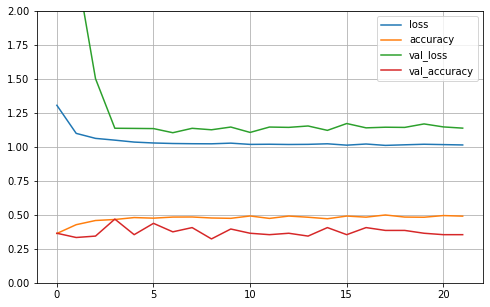

In [21]:
pd.DataFrame(history_dense.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

## Podział nauki na bloki 

In [22]:
blocking = StartSplit(n_blocks = 8, train_split = 200, scoring = metrics.accuracy_score)

In [23]:
#Wyczyszczenie sesji i ustawienie ziarna losowaości na 42
tf.keras.backend.clear_session()
tf.random.set_seed(42)

#pobranie przygotowanego modelu SNN
model_dense_blocks = get_model()
#kompilacja modelu z wybranymi parametrami
model_dense.compile(optimizer='nadam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
#Proces nauki modelu
model_dense_blocks.compile(optimizer='nadam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

#Przygotowanie danych
dataset2 = prepare_dataset(all_seasons, list_of_parameters, all_data_past,
                          add_direct = True, avg = 3, train_size = 1.0, test_size = 0.0,
                          undersample = True, globalCS = False)
X_dataset_blocks = np.array(dataset2['X_train'])
y_dataset_blocks = np.array(dataset2['y_train'])

#Proces nauki
global_accuracy = list()
for block_idx, (train_ind, test_ind) in enumerate(blocking.generate_cv(X_dataset_blocks, y_dataset_blocks)):
    #Ustawienie ziarna losowaości na 42
    tf.random.set_seed(42)
    #kompilacja modelu z wybranymi parametrami
    model_dense_blocks.compile(optimizer='nadam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
    #Nuaka modelu w  podejściu blokowym
    valid_len = len(train_ind)*90//100
    history_dense = model_dense_blocks.fit(X_dataset_blocks[train_ind][:valid_len], 
                                           y_dataset_blocks[train_ind][:valid_len], 
                                           validation_data=(X_dataset_blocks[train_ind][valid_len:], 
                                                            y_dataset_blocks[train_ind][valid_len:]),
                                            epochs = 80, callbacks=[early_stopping_cb], verbose = 0)
    
    #Obliczanie wyniku uzyskanego na zbiorze testowym
    y_probas_dense = np.stack([model_dense_blocks(X_dataset_blocks[test_ind]) for sample in range(100)])
    y_proba_dense = y_probas_dense.mean(axis=0)

    result_dense_block = list()
    for i in range(y_proba_dense.shape[0]):
        result_dense_block.append(np.argmax(y_proba_dense[i]))
    global_accuracy.append(result_dense_block == y_dataset_blocks[test_ind])
    accuracy = np.sum(result_dense_block == y_dataset_blocks[test_ind]) / len(y_dataset_blocks[test_ind])
    print(f'{block_idx + 1}\tAccuracy: {accuracy}')
    #print('\n##################################\nPrecision, Recall and fscore: ')
    #print(precision_recall_fscore_support(y_dataset_blocks[test_ind], result_dense, average='macro'))
    
print(f"\n")
print(f"Global Accuracy: {np.sum(np.concatenate(np.array(global_accuracy)))/len(np.concatenate(np.array(global_accuracy)))}")


1	Accuracy: 0.375
2	Accuracy: 0.405
3	Accuracy: 0.51
4	Accuracy: 0.495
5	Accuracy: 0.51
6	Accuracy: 0.515
7	Accuracy: 0.385
8	Accuracy: 0.42


Global Accuracy: 0.451875


## Wyliczenie wartości shapley'a dla standardowego podejścia SNN

In [24]:
shap.initjs()

In [25]:
X_train_shap = np.array(dataset['X_train'])
X_test_shap = np.array(dataset['X_test'])

In [48]:
X_train_shap_summary = shap.sample(X_train_shap, 100)
explainer = shap.KernelExplainer(model_dense.predict, X_train_shap_summary)
shap_values = explainer.shap_values(X_test_shap, nsamples=100)

In [72]:
#Zapis wyliczonych wartości do pliku
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'explainer_SNN.pkl')
with open(ex_filename, "wb") as f:
    pickle.dump(explainer.expected_value, f)
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'shap_values_SNN.pkl')
with open(ex_filename, "wb") as f:
    pickle.dump(shap_values, f)

In [73]:
#Odczyt poprzednio obliczonych wartości
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'explainer_SNN.pkl')
with open(ex_filename, 'rb') as f:
    explainer = pickle.load(f)
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'shap_values_SNN.pkl')
with open(ex_filename, 'rb') as f:
    shap_values = pickle.load(f)

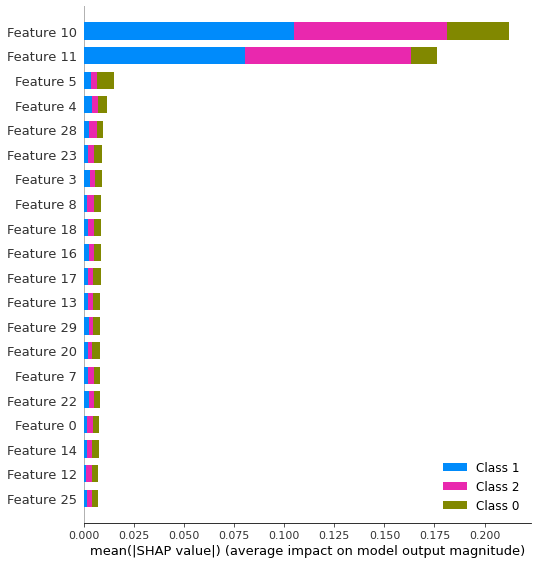

In [74]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

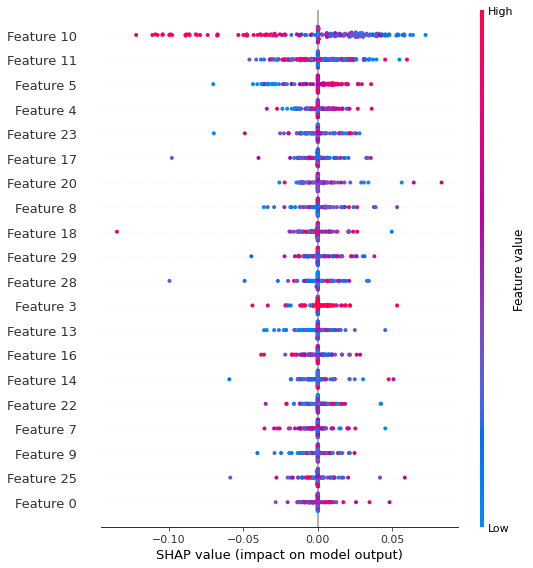

In [75]:
shap.summary_plot(shap_values[0], X_test_shap)

In [76]:
INSTANCE_NUM = 0
shap.force_plot(explainer[0], shap_values[0][INSTANCE_NUM], X_test_shap[INSTANCE_NUM])

In [77]:
NUM_ROWS = 10
shap.force_plot(explainer[0], shap_values[0][0:NUM_ROWS], X_test_shap[0:NUM_ROWS])

## Wizualizacja uzyskanych wyników (metoda: TSNE)

In [40]:
def draw2D(dataset, labels, loc_str = 'upper right', palette = 'deep', figsize = (13,13)): 
    warnings.simplefilter("ignore")
    
    plt.figure(figsize = figsize)
    ax = sns.scatterplot(dataset[:, 0], dataset[:, 1], palette = palette, hue = labels, c = labels)
    plt.title("2D decomposition")
    plt.xlabel("Z1")
    plt.ylabel("Z2")  
    plt.legend(loc = loc_str)

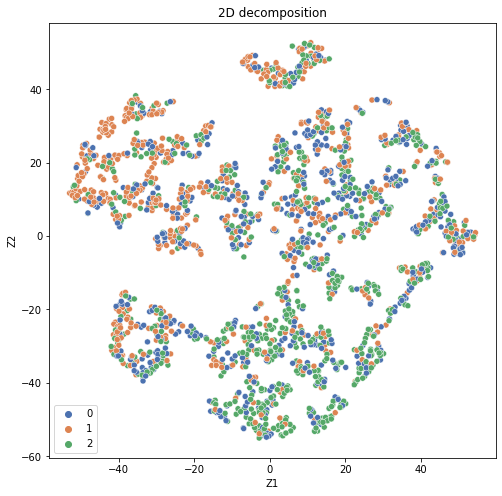

In [41]:
from sklearn.manifold import TSNE
tsne2 = TSNE(n_components=2)
tsne2_data_all = tsne2.fit_transform(pd.get_dummies(dataset['X']))
draw2D(tsne2_data_all, dataset['y'], loc_str = 'lower left', figsize = (8,8))

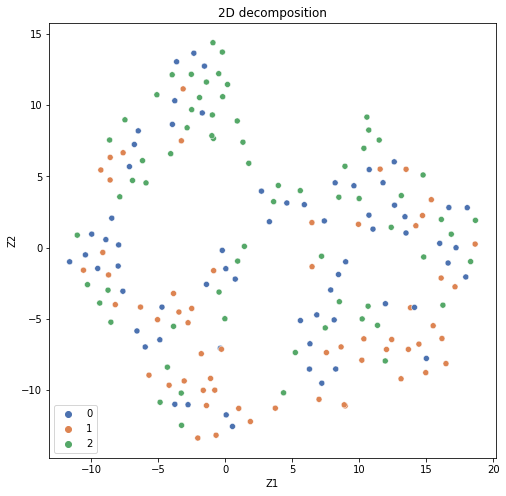

In [42]:
tsne2 = TSNE(n_components=2)
tsne2_data_dense = tsne2.fit_transform(np.array(dataset['X_test']))
draw2D(tsne2_data_dense, dataset['y_test'], loc_str = 'lower left', figsize = (8,8))

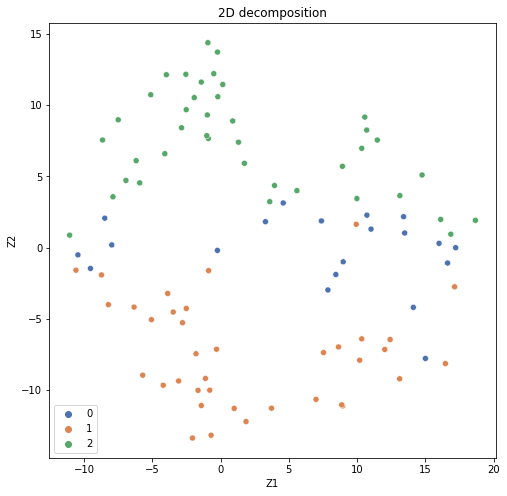

In [43]:
tsne2 = TSNE(n_components=2)
#tsne2_data = tsne2.fit_transform(tsne2_data_dense[result_dense == y_test])
draw2D(tsne2_data_dense[result_dense == (dataset['y_test'])], 
       dataset['y_test'][result_dense == dataset['y_test']], 
       loc_str = 'lower left', figsize = (8,8))

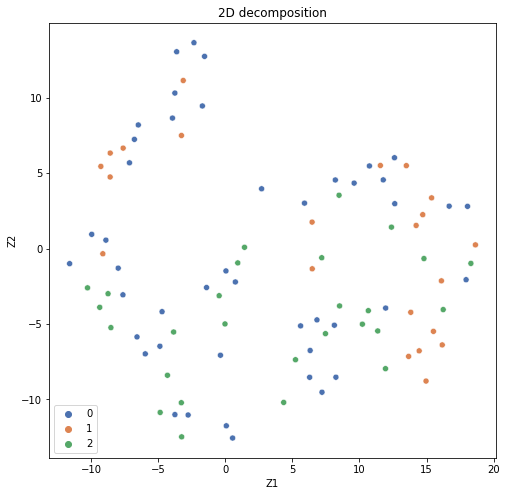

In [44]:
tsne2 = TSNE(n_components=2)
#tsne2_data = tsne2.fit_transform(X_test_dense[result_dense != y_test])
draw2D(tsne2_data_dense[result_dense != dataset['y_test']], dataset['y_test'][result_dense != dataset['y_test']], 
       loc_str = 'lower left', figsize = (8,8))

<AxesSubplot:>

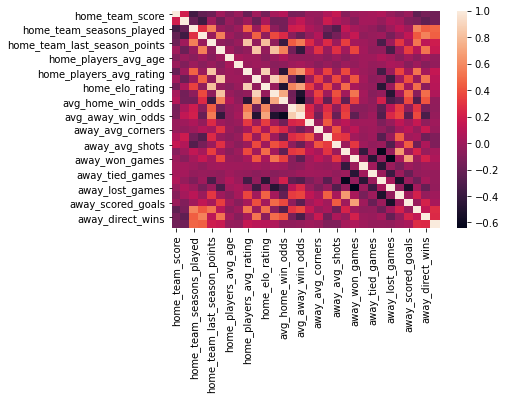

In [45]:
corr = dataset['X'].corr()
sns.heatmap(corr)

## Nauczenie modelu na całym dostępnym zbiorze danych i zapis go w celu wykorzystania do do interaktywnego notebooka

In [46]:
dataset_final = prepare_dataset(all_seasons, list_of_parameters, all_data_past,
                          add_direct = True, avg = 3, train_size = 1.0, test_size = 0.0,
                          undersample = True, globalCS = False)

X_train_dense_final = np.array(dataset_final['X_train'])

#Wyczyszczenie sesji i ustawienie ziarna losowaości na 42
tf.keras.backend.clear_session()
tf.random.set_seed(42)

#pobranie przygotowanego modelu SNN
model_dense_final = get_model()

#kompilacja modelu z wybranymi parametrami
model_dense_final.compile(optimizer='nadam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
#Proces nauki modelu
history_dense_final = model_dense_final.fit(X_train_dense_final, dataset_final['y_train'], epochs = 21, verbose = 0)

In [47]:
#Zapis modelu do pliku
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'SNN.h5')
model_dense_final.save_weights(ex_filename)